In [393]:
import os
os.environ["SOCCERDATA_DIR"] = "../soccerdata"

import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from matplotlib import font_manager

from mplsoccer.pitch import Pitch

In [76]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68

In [103]:
def inverted_coordinates(coords, max_value):
    return 2 * max_value/2 - coords
    

# Load data

In [372]:
with open("../sofascore/data/shotmap.json") as f:
    shotmap = json.load(f)

shots = pd.json_normalize(shotmap["shotmap"])
shots.head()

,isHome,shotType,situation,bodyPart,goalMouthLocation,xg,id,time,addedTime,timeSeconds,...,draw.end.y,draw.goal.x,draw.goal.y,blockCoordinates.x,blockCoordinates.y,blockCoordinates.z,draw.block.x,draw.block.y,xgot,goalType
0,True,miss,penalty,right-foot,close-left,0.788400,2247983,90,7.0,5817,...,0,42.4,98.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,block,assisted,right-foot,low-centre,0.043258,2247976,90,6.0,5702,...,0,48.3,81.0,11.5,56.5,0.0,56.5,11.5,NaN,NaN
2,True,save,assisted,head,low-right,0.058861,2247967,90,NaN,5353,...,0,52.3,89.2,1.4,48.4,0.0,48.4,1.4,0.1117,NaN
3,True,miss,assisted,right-foot,close-left,0.030304,2247958,86,NaN,5124,...,0,41.0,94.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,save,free-kick,right-foot,low-right,0.051087,2247950,84,NaN,5000,...,0,53.7,92.4,1.1,48.9,0.0,48.9,1.1,0.2494,NaN


In [373]:
# Antwerp shots
home_shots = shots[shots["isHome"] == True]
home_goal_shots = home_shots[home_shots["shotType"] == "goal"]
home_non_goal_shots = home_shots[home_shots["shotType"] != "goal"]

home_goal_shots_x = home_goal_shots["playerCoordinates.x"]/100 * PITCH_LENGTH
home_goal_shots_y = home_goal_shots["playerCoordinates.y"]/100 * PITCH_WIDTH
home_non_goal_shots_x = home_non_goal_shots["playerCoordinates.x"]/100 * PITCH_LENGTH
home_non_goal_shots_y = home_non_goal_shots["playerCoordinates.y"]/100 * PITCH_WIDTH

# Shakhtar shots
away_shots = shots[shots["isHome"] == False]
away_goal_shots = away_shots[away_shots["shotType"] == "goal"]
away_non_goal_shots = away_shots[away_shots["shotType"] != "goal"]

away_goal_shots_x = inverted_coordinates(away_goal_shots["playerCoordinates.x"]/100 * PITCH_LENGTH, PITCH_LENGTH)
away_goal_shots_y = inverted_coordinates(away_goal_shots["playerCoordinates.y"]/100 * PITCH_WIDTH, PITCH_WIDTH)
away_non_goal_shots_x = inverted_coordinates(away_non_goal_shots["playerCoordinates.x"]/100 * PITCH_LENGTH, PITCH_LENGTH)
away_non_goal_shots_y = inverted_coordinates(away_non_goal_shots["playerCoordinates.y"]/100 * PITCH_WIDTH, PITCH_WIDTH)

In [374]:
with open("../sofascore/data/statistics.json") as f:
    statistics = json.load(f)

data = []
for period in statistics["statistics"]:
    for group in period["groups"]:
        group_name = group["groupName"]
        home = group["statisticsItems"][0]["home"]
        away = group["statisticsItems"][0]["away"]
        data.append([period["period"], group_name, home, away])

df_statistics = pd.DataFrame(data, columns=["period", "groupName", "home", "away"])
df_statistics

,period,groupName,home,away
0,ALL,Expected,1.84,2.27
1,ALL,Possession,53%,47%
2,ALL,Shots,13,16
3,ALL,TVData,2,4
4,ALL,Shots extra,2,4
5,ALL,Passes,517,461
6,ALL,Duels,8/17 (47%),6/9 (67%)
7,ALL,Defending,14,22
8,1ST,Expected,0.54,0.45
9,1ST,Possession,58%,42%


In [379]:
all_statistics = df_statistics[df_statistics["period"] == "ALL"]

home_goal_count = len(home_goal_shots)
home_shot_count = len(home_shots)
home_on_target_count = len(home_shots[home_shots["shotType"] != "miss"])
home_xg = all_statistics[all_statistics["groupName"] == "Expected"].home.values[0]
home_possession = all_statistics[all_statistics["groupName"] == "Possession"].home.values[0]

away_goal_count = len(away_goal_shots)
away_shot_count = len(away_shots)
away_on_target_count = len(away_shots[away_shots["shotType"] != "miss"])
away_xg = all_statistics[all_statistics["groupName"] == "Expected"].away.values[0]
away_possession = all_statistics[all_statistics["groupName"] == "Possession"].away.values[0]

# Plot shots

In [407]:
def set_plot_title(suptitle, title):
    prop = font_manager.FontProperties(fname="../fonts/Champions-Bold.ttf")
    
    plt.suptitle(suptitle, fontsize=20, fontproperties=prop)
    plt.title(title, fontsize=14, fontproperties=prop, color="gray")

In [390]:
def plot_logos(pitch):
    home_logo = mpimg.imread("../images/antwerp_logo.png")
    away_logo = mpimg.imread("../images/shakhtar_logo.png")

    pitch.inset_image(x=40, y=55, image=home_logo, width=10, ax=ax)
    pitch.inset_image(x=65, y=55, image=away_logo, width=10, ax=ax)


In [399]:
def plot_match_statistics():    
    def stats_text_options(facecolor):
        return {
            "ha": "center", 
            "va": "center", 
            "fontsize": 10, 
            "color": "w", 
            "bbox": {
                "facecolor": facecolor,
                "edgecolor": "None",
                "boxstyle": "round,pad=0.2"
            }
        }

    name_stat_x = PITCH_LENGTH/2
    home_stat_x = stats_center_x - 12.5
    away_stat_x = stats_center_x + 12.5
    row_height = 6
    
    y = 46 
    plt.text(home_stat_x, y, home_goal_count, **stats_text_options(facecolor="tomato"))
    plt.text(name_stat_x, y, "Goals", **stats_text_options(facecolor="dimgray"))
    plt.text(away_stat_x, y, away_goal_count, **stats_text_options(facecolor="tomato"))

    y -= row_height
    plt.text(home_stat_x, y, home_xg, **stats_text_options(facecolor="tomato"))
    plt.text(name_stat_x, y, "xG", **stats_text_options(facecolor="dimgray"))
    plt.text(away_stat_x, y, away_xg, **stats_text_options(facecolor="tomato"))

    y -= row_height
    plt.text(home_stat_x, y, home_shot_count, **stats_text_options(facecolor="tomato"))
    plt.text(name_stat_x, y, "Shots", **stats_text_options(facecolor="dimgray"))
    plt.text(away_stat_x, y, away_shot_count, **stats_text_options(facecolor="tomato"))

    y -= row_height
    plt.text(home_stat_x, y, home_on_target_count, **stats_text_options(facecolor="tomato"))
    plt.text(name_stat_x, y, "On Target", **stats_text_options(facecolor="dimgray"))
    plt.text(away_stat_x, y, away_on_target_count, **stats_text_options(facecolor="tomato"))

    y -= row_height
    plt.text(home_stat_x, y, home_possession, **stats_text_options(facecolor="tomato"))
    plt.text(name_stat_x, y, "Possession", **stats_text_options(facecolor="dimgray"))
    plt.text(away_stat_x, y, away_possession, **stats_text_options(facecolor="tomato"))

In [400]:
def plot_legend(ax):
    markersizes = list(range(2, 15, 3))
    
    legend_outcome_markers = [
        Line2D([0], [0], marker="o", color="w", markeredgecolor="steelblue", markersize=markersizes[-2]),
        Line2D([0], [0], marker="o", color="w", markeredgecolor="dimgray", markerfacecolor="tomato", markersize=markersizes[-2])
    ]
    
    legend_xg_value_markers = [Line2D([0], [0], marker="o", color="w", markeredgecolor="dimgray", markersize=size) for size in markersizes]
    
    legend1 = ax.legend(
        legend_outcome_markers, 
        ["Shot", "Goal"], 
        ncol=len(legend_outcome_markers), 
        title="Outcomes", 
        bbox_to_anchor=(0.45, 0.05),
        columnspacing=0.5,
        frameon=False
    )
    
    ax.add_artist(legend1)
    
    legend2 = ax.legend(
        legend_xg_value_markers, 
        [""] * len(legend_xg_value_markers), 
        ncol=len(legend_xg_value_markers), 
        title="xG value", 
        bbox_to_anchor=(0.7, 0.05),
        columnspacing=0.5,
        frameon=False
    )   

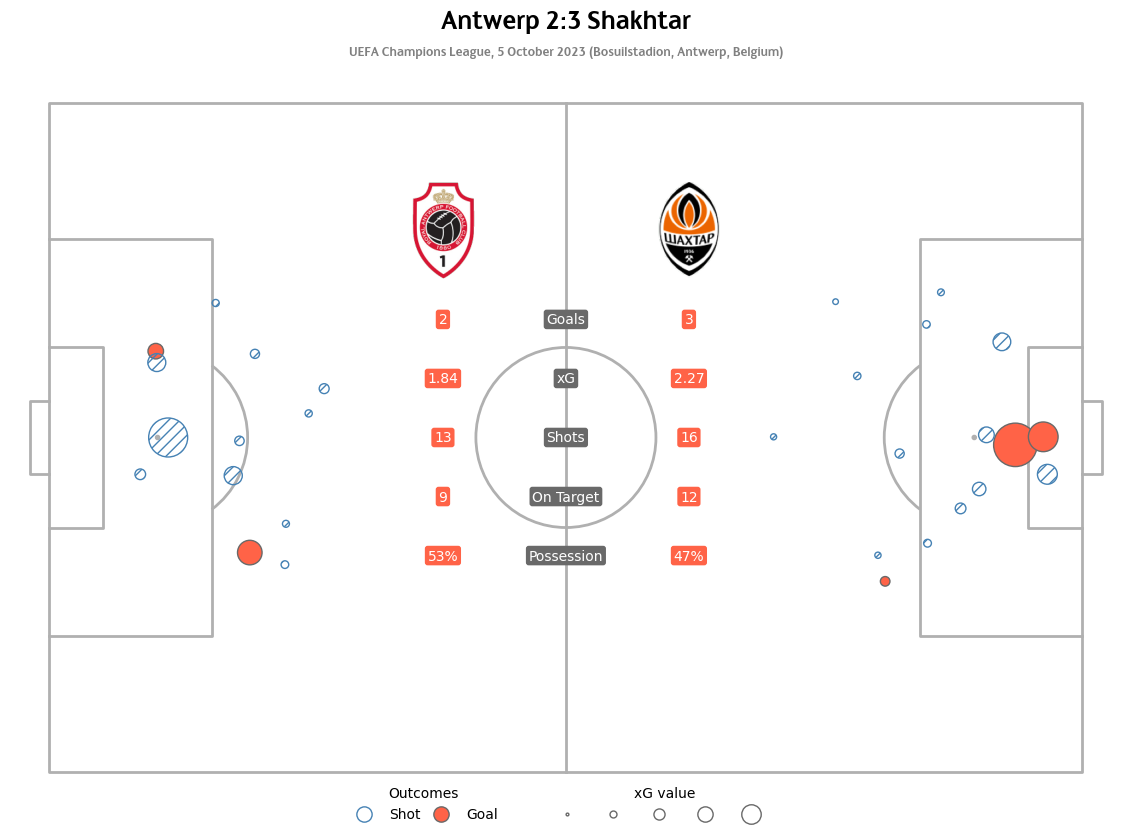

In [408]:
pitch = Pitch(pitch_type="custom", pitch_length=PITCH_LENGTH, pitch_width=PITCH_WIDTH, goal_type="box")
fig, ax = pitch.draw(figsize=(13, 8.5))

set_plot_title(
    suptitle="Antwerp 2:3 Shakhtar", 
    title="UEFA Champions League, 5 October 2023 (Bosuilstadion, Antwerp, Belgium)"
)

pitch.scatter(
    x=home_goal_shots_x, 
    y=home_goal_shots_y, 
    s=home_goal_shots.xg * 1000,
    edgecolors="dimgray", 
    c="tomato", 
    marker="o", 
    ax=ax
)

pitch.scatter(
    x=home_non_goal_shots_x, 
    y=home_non_goal_shots_y, 
    s=home_non_goal_shots.xg * 1000,
    edgecolors="steelblue", 
    c="None",
    hatch="///",
    marker="o", 
    ax=ax
)

pitch.scatter(
    x=away_goal_shots_x, 
    y=away_goal_shots_y, 
    s=away_goal_shots.xg * 1000,
    edgecolors="dimgray", 
    c="tomato", 
    marker="o", 
    ax=ax
)

pitch.scatter(
    x=away_non_goal_shots_x, 
    y=away_non_goal_shots_y, 
    s=away_non_goal_shots.xg * 1000,
    edgecolors="steelblue",
    c="None", 
    hatch="///",
    marker="o", 
    ax=ax
)

plot_logos(pitch=pitch)
plot_match_statistics()
plot_legend(ax=ax)

plt.savefig("../report/shotmap.png", dpi=300, bbox_inches="tight")